In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as random 
# TODO: Specify the seed so random things are generated again
# %matplotlib qt

from timer_module import TimerModule as TM

In [2]:
def relative_to_absolute_event_time(relative_time_events, NUM_EVENTS):
    # TODO: Change this to a simple cumsum on the first column
    absolute_time_events = relative_time_events   
    for i in range (1,NUM_EVENTS):
        absolute_time_events[i][0] = relative_time_events[i-1][0] + relative_time_events[i][0]
    return absolute_time_events  

def activationAtIntervalEnd(timer, ramp_index, interval_length, c):
    # Simulate DDM process for activation amount
    # Change act to activation
    act = timer.timers[ramp_index] * interval_length
    for i in range (0, len(act)):
        act[i] = act[i] + c * np.sqrt(act[i]) * np.random.normal(0, 1) * math.sqrt(interval_length)
    return act

def activationAtIntervalEndHierarchical(timer, ramp_index, interval_length, next_stimulus_type, c):
    # Simulate DDM process for activation amount
    # Change act to activation
    delta = 0.5
    '''
    assigned_ramps = []
    for timer_idx in ramp_index:
        if timer.terminating_events[ramp_index] == next_stimulus_type:
            assigned_ramps.append(timer_idx)
    '''       
    act = timer.timers[ramp_index] * interval_length
    # print(f'ramp_index: {ramp_index}')
    for i in range (0, len(act)):
        act[i] = act[i] + c * np.sqrt(act[i]) * np.random.normal(0, 1) * math.sqrt(interval_length)
    f_act = act * act
    
    # print(f'act: {act}')
    
    #for timer_act in act:
    #    hier_act = timer_act + 1/((act.size)-1) * delta * f_act[act != timer_act].sum()

    return act

def update_and_reassign_ramps(timer, timer_values, timer_indices, next_stimulus_type, stimulus_type, external_idx, allocation_prob, NUM_RAMPS, RAMPS_PER_EVENT, sequence_code = '', v0=1.0, z = 1, bias = 1, plot = False):
    # Frozen timers arent updated
    for idx, value in zip(timer_indices, timer_values):
        if idx in timer.frozen_ramps:
            continue
        
        # Generate coin flip for random update
        flip = random.random()

        if idx in timer.free_ramps:
            stim_type_y_plot_val = (NUM_RAMPS/2) - (NUM_RAMPS/4)
            next_stim_type_y_plot_val = (NUM_RAMPS/2) - (NUM_RAMPS/4)
        
        """ 
        From all the ramps not idle who have either:
            - S2=e_i and start<act<stop
            - S2 = NA
        Pick N randomly and update them for the interval s1->s2=e_i
        """
        # If a timer is unassigned
        if len(np.where(timer.terminating_events[np.where(timer.initiating_events == stimulus_type)] == next_stimulus_type)[0])>RAMPS_PER_EVENT:
            continue
        
        
        if timer.terminating_events[idx] == -1:
            if flip >=allocation_prob: # Update this to be a var, not a magic number
                # if the timer has the appropriate terminating event, update the weight
                if value > 1:
                    ''' Early Update Rule '''
                    timer_weight = earlyUpdateRule(value, timer.timerWeight(idx), timer.learningRate(idx))
                   
                    
                else:
                    ''' Late Update Rule '''
                    timer_weight = lateUpdateRule(value, timer.timerWeight(idx), timer.learningRate(idx))
                        
                timer.terminating_events[idx] = next_stimulus_type
                if idx in timer.free_ramps:
                    timer.setTimerWeight(timer_weight, idx)
                    timer.free_ramps = np.delete(timer.free_ramps, np.where(timer.free_ramps == idx))
                    timer.initiating_events[idx] = stimulus_type
                    
            continue
        
        if timer.terminating_events[idx] == next_stimulus_type and timer.initiating_events[idx] == stimulus_type:
            if flip>=.9:
                if value > 1:
                    ''' Early Update Rule '''
                    #plot_early_update_rule(start_time, end_time, timer_weight, T, event_type, value)
                    timer_weight = earlyUpdateRule(value, timer.timerWeight(idx), timer.learningRate(idx))
                    # timer.setTimerWeight(timer_weight, idx)
                        
                else:
                    ''' Late Update Rule '''
                    timer_weight = lateUpdateRule(value, timer.timerWeight(idx), timer.learningRate(idx))
                timer.setTimerWeight(timer_weight, idx) 
                
def lateUpdateRule(vt, timer_weight, learning_rate, v0=1.0, z = 1, bias = 1):
    """
    TODO: these are out of order
    Include data types in each of these
    
    Parameters
    ----------
    v0: activation of IN unit
    z: desired activation, threshold
    Vt: timer unit activation
    bias: bias of timer unit
    timer_weight: the weight of the timer
    Returns 
    -------
    The corrected timer weight for the associated event
    """

    drift = (timer_weight * v0)
    d_A = drift * ((1-vt)/vt)
    ret_weight = timer_weight + (learning_rate * d_A)
    return ret_weight
                
def earlyUpdateRule(vt, timer_weight, learning_rate, v0=1.0, z = 1, bias = 1):
    """
    Parameters
    ----------
    v0: activation of IN unit
    z: desired activation, threshold
    Vt: timer unit activation
    bias: bias of timer unit
    timer_weight: the weight of the timer
    Returns 
    -------
    The corrected timer weight for the associated event
    """
    drift = (timer_weight * v0)
    d_A = drift * ((vt-z)/vt)
    ret_weight = timer_weight - (learning_rate * d_A)
    return ret_weight

def start_threshold_time(act_at_interval_end, interval_length,START_THRESHOLD):
    # Time of ramp hitting start threshold
    # TODO: get rid of magic numbers here
    angle = np.arctan(act_at_interval_end/interval_length)
    beta = 3.14159 - (1.5708 + angle)
    return START_THRESHOLD * np.tan(3.14159 - (1.5708 + angle))

def stop_threshold_time(act_at_interval_end, interval_length,STOP_THRESHOLD):
    # Time of ramp hitting stop threshold
    angle = np.arctan(act_at_interval_end/interval_length)
    beta = 3.14159 - (1.5708 + angle)
    return STOP_THRESHOLD * np.tan(3.14159 - (1.5708 + angle))

def generate_responses(interval_length, dt, num_samples):
    num_samples = int(interval_length / dt)
    responses = np.random.exponential(1, num_samples)
    return responses


def respond(timer_value, event_time, next_event, START_THRESHOLD, STOP_THRESHOLD, dt, num_samples, K, idx):
    # Given all ramp vaues, respond when K are between start and stop range
    # K is a global declared later on, tyically == 5
    
    # Find start threshold times for each ramp
    start_threshold_times = start_threshold_time(timer_value, next_event-event_time, START_THRESHOLD)
    start_threshold_times += event_time
    start_threshold_times.sort()
    start_threshold_times = np.vstack((start_threshold_times, np.ones(len(start_threshold_times)))).T
    
    # Find stop threshold times for each ramp
    stop_threshold_times = stop_threshold_time(timer_value, next_event-event_time, STOP_THRESHOLD)
    stop_threshold_times += event_time
    stop_threshold_times.sort()
    stop_threshold_times = np.vstack((stop_threshold_times, (-1* np.ones(len(stop_threshold_times))))).T
    
    # Zip start and stop times
    start_stop_pairs = np.vstack((start_threshold_times, stop_threshold_times))
    start_stop_pairs = start_stop_pairs[start_stop_pairs[:, 0].argsort()]

    # TODO: Preallocate memory instead of initializing an empty list
    responses = []
    response_periods = []
    k = 0
    k_o = 0 # Old value of k
    
    # Form list of start and stop events, sorted by time (a1, sig1, a2, a3, sig2, sig3 etc)
    # Loop through all, if start event, k++, else, k--
    # Identify all periods of k > K
    # Fill with Poisson seq (samples then add the start time to all of them)
    # once theyre greater than the boundary where they stop, throw them out
    for jdx, time in enumerate(start_stop_pairs):
        k+=time[1]
        # print(f'k: {k} \t time: {time[0]}')
        # We're entering a response period
        if k_o < K and k >= K:
            response_period_start = time[0]
        if k_o >=K and k < K:
            response_period_end = time[0]
            response_periods.append([response_period_start, response_period_end])
        k_o+=time[1]
    
    r = list(generate_responses(next_event-event_time, dt, num_samples))
    r.insert(0, event_time)
    r=list(np.cumsum(r))
    # print('===')
    # print(f'{event_time} / {next_event}')
    for response_period in response_periods:
        responses.extend([i for i in r if (i>response_period[0] and i<response_period[1] and i<next_event and i>event_time)])
        
    
    # responses and ax1.text(responses[0],1.2,str(idx))
    return responses

In [3]:
def sigmoid(x, amp=20, ceiling=1):
    return ceiling / (1 + np.exp(-amp * x))

In [7]:
def main(parameters, plot=True):
    dt = parameters["dt"]
    N_EVENT_TYPES= parameters["N_EV_TYPES"] # Number of event types (think, stimulus A, stimulus B, ...)
    Y_LIM=2 # Vertical plotting limit
    NOISE=parameters["NOISE"] # Internal noise - timer activation
    LEARNING_RATE=parameters["lr"] # Default learning rate for timers
    ALLOCATION_PROB = parameters["allocation_prob"]
    STANDARD_INTERVAL=20 # Standard interval duration 
    K = parameters["k"] # Amount of timers that must be active to respond
    
    RR_est_tau = 200
    
    # hill climbing params
    START_THRESHOLD=parameters["start_thresh"]# Response start threshold
    STOP_THRESHOLD=parameters["stop_thresh"] # Response stop threshold
    c = 0.1 # noise for iteration, separate from internal neural noise
    baseline_noise = 0.5
    noise_scale = 1
    scale = 100
    reward_vals = [0]
    R_hat = R_delay = 1.0
    R_hat_vals = [R_hat]
    R_delay_vals = [R_delay]
    
    start_hat = start_delay = START_THRESHOLD
    stop_hat = stop_delay = STOP_THRESHOLD
    
    start_hat_vals = []
    start_delay_vals = []
    
    stop_hat_vals = []
    stop_delay_vals = []
    
    R_hat_dot_delay = 0
    R_hat_dot_dot_delay = 0
    R_hat_dot_delay_vals = []
    start_hat_dot_vals = []
    stop_hat_dot_vals = []
    R_hat_dot_vals = []
    R_hat_dot_dot_vals = []
    noise_vals = [baseline_noise]
    
    path = [(START_THRESHOLD, STOP_THRESHOLD)]
    tau_iteration = 10
    
    # End iteration params
    PLOT_FREE_TIMERS=False
    ERROR_ANALYSIS_RESPONSES=[]
    BEAT_THE_CLOCK = False
    colors = [[1,0,0], [0,1,0], [0,0,1], [1,1,0], [0,1,1], [1,0,1],[.46,.03,0], [.1,.3,.2], [.2,.7,.2], [.5,.3,.6], [.7,.3,.4]]# list(mcolors.CSS4_COLORS) # Color support for events
    ALPHABET_ARR = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','AA','BB','CC'] # For converting event types into letters 
    RESPONSE_THRESHOLD_LEARNING_RATE = .6
    NUM_RAMPS = parameters["num_ramps"]
    RAMPS_PER_EVENT = parameters["ramps_per_event"]
    reward_window_plot = 1600
    reward_window_sim = 1600
    x_lb = np.linspace(-reward_window_plot * dt,0, reward_window_plot)
    exp_weighted_average = np.exp(x_lb * .01)
    
    event_data = []
    cur_RR = 0
    old_RR = 0
    expand = True 
    contract = False
    random_seq = False
    seq_length = 3

    # Initialize events
    if random_seq:
        random_samples = TM.getSamples(seq_length, num_normal = 3, seed = 12, scale_beg = 20, scale_end = 50)
        event_data = [[0,0,0]]
        for sample in random_samples:
            event_data.append([sample[0], sample[1], sample[2]])
            
        HOUSE_LIGHT_ON = [*range(0,seq_length-1,1)] + [*range(seq_length,(seq_length*2)-1,1)] + [*range(seq_length*2,(seq_length*3)-3,1)] + [*range(seq_length*3,(seq_length*4)-3,1)]
        event_data = TM.getEvents(num_samples=seq_length, num_normal = 2, deviation=2, num_exp = 0, repeat = 3, scale_beg = 20, scale_end=30)
        
    else:
        HOUSE_LIGHT_ON = [*range(0,1,1)] + [*range(2,3,1)] + [*range(4,5,1)] + [*range(6,7,1)] +  [*range(8,9,1)] + [*range(10,11,1)] + [*range(12,13,1)] + [*range(14,15,1)] + [*range(16,17,1)] + [*range(18,19,1)] + [*range(20,21,1)] + [*range(22,23,1)] #[*range(9,10,1)] + [*range(11,12,1)] + [*range(13,14,1)] +[*range(13,14,1)]
        event_data = np.asarray([[0,1,1], [50,0,0], [25,1,1],
                              [50,0,0], [25,1,1], [50,0,0], 
                              [25,1,1], [50,0,0], [25,1,1], 
                              [50,0,0], [25,1,1], [50,0,0], 
                              [25,1,1], [50,0,0], [25,1,1], 
                              [50,0,0], [25,1,1], [50,0,0],
                              [25,1,1], [50,0,0], [25,1,1],
                              [50,0,0], [25,1,1], [50,0,0],
                              [25,1,1], [50,0,0], [25,1,1],
                              [50,0,0], [25,1,1], [50,0,0],
                              [25,1,1], [50,0,0], [25,1,1],
                              [25,1,1], [50,0,0], [25,1,1],
                              [25,1,1], [50,0,0], [25,1,1]])                        
    
    # TODO: Make start threhsolds an array of values
    seq_len =  4
    repeat_num = 3
    penalty=.1

    NUM_EVENTS = len(event_data) 
    btc_reward=np.empty(NUM_EVENTS)

    error_arr = np.zeros(NUM_EVENTS)
    event_data = relative_to_absolute_event_time(event_data, NUM_EVENTS)
    event_data[0][2] = event_data[seq_len][2]

    # Last event, time axis for plotting        
    T = event_data[HOUSE_LIGHT_ON[-1]+1][0]
    
    # Timer with 100 (or however many you want) ramps, all initialized to be very highly weighted (n=1)
    timer=TM(1,NUM_RAMPS)
    if plot:
        simple_learning_fig = plt.figure(figsize=(8,4))
        # simple_learning_fig.suptitle('Simple Learning Sequence', fontsize=16)
        ax1 = simple_learning_fig.add_subplot(311)
        ax2 = simple_learning_fig.add_subplot(312, sharex = ax1)
        ax3 = simple_learning_fig.add_subplot(313, sharex = ax1)
        # ax4 = simple_learning_fig.add_subplot(314)
    
        ax1.set_ylim([0,Y_LIM])
        ax1.set_xlim([0,T])
    
        ax2.set_ylim([0,1])
        ax2.set_xlim([0,T])
        ax3.set_xlim([0,T])

    reward_arr_plot = np.zeros(int(event_data[HOUSE_LIGHT_ON[-1]+1][0] / dt))

    timer_plot_legend_free = {}
    timer_plot_legend_assigned = {}

    # Initialize a reward arr that has a small amount of reward at each time step
    reward_arr = np.zeros(int(event_data[HOUSE_LIGHT_ON[-1]+1][0]/dt))
    if plot:
        reward_x_axis = np.linspace(0,event_data[HOUSE_LIGHT_ON[-1]+1][0]/dt,reward_arr.shape[0])

    # Define hidden states
#     hidden_states = [175, 325, 475]
#     for hidden_state in hidden_states:
#         reward_arr[int(hidden_state/dt)] = 1
        
    # For event, add a large amount of reward at the event and a little right before it 
    for index, event in enumerate(event_data[1:]):
        if index in HOUSE_LIGHT_ON or (index) in HOUSE_LIGHT_ON:
            if int(event[0]/dt) < reward_arr.shape[0]:
                reward_arr[int(event[0]/dt)] = 1
                exp_arr = np.exp(-.5 * np.arange(0, 20, dt))[::-1]
                reward_arr[int(event[0]/dt) - exp_arr.shape[0]:int(event[0]/dt)] = exp_arr

    reward_arr[0] = 0 
        
#     if plot:
#         for state in hidden_states:
#             ax2.plot(state, .9, marker = '*', color='r', label="hidden state")
        
    ''' Simulation Start '''
    # At each event e_i
    reward_est_vals = np.zeros(8750)
    run_twice = 2
    reward_estimation = [0]
    for idx, event in enumerate(event_data[:HOUSE_LIGHT_ON[-1]]):
        path.append((START_THRESHOLD, STOP_THRESHOLD))
        
        house_light = idx in HOUSE_LIGHT_ON
        event_time = event[0]
        event_type = int(event[1])
        stimulus_type = int(event[2])
        next_event = event_data[idx+1][0]
        next_stimulus_type=int(event_data[idx+1][2])
        
        # Plot event times and labels
        if idx < (NUM_EVENTS - 1):
            if plot:
                ax1.text(event[0],2.1,ALPHABET_ARR[int(event_data[idx+1][2])])
                ax1.vlines(event_time, 0,Y_LIM, label="v", color=colors[next_stimulus_type])
                
        if house_light:
            # Plot house light bar
            if plot:
                house_light_bar = ax1.plot([event_time, next_event], [1.9, 1.9], 'k-', lw=4)  
                ax1.plot([event_time, next_event], [1.9, 1.9], 'k-', lw=4)  
            # Look forward to all other intervals before house light turns off and start updating weights
            house_light_idx = idx + 1
            house_light_interval = True
            tau=200
            while house_light_interval:
                # If the next interval is in the house light period
                if house_light_idx-1 in HOUSE_LIGHT_ON: 
                    # Get next event time and stimulus type
                    next_house_light_event_time = event_data[house_light_idx][0]
                    next_house_light_stimulus_type = event_data[house_light_idx][2]
                    
                    # All indices of ramps active by initiating event
                    initiating_active_indices = np.where(timer.initiating_events == stimulus_type)
                    
                    # All initiating and free ramp indices
                    active_ramp_indices = np.append(initiating_active_indices, timer.free_ramps)
                    
                    house_light_timer_value = activationAtIntervalEnd(timer, active_ramp_indices, next_house_light_event_time - event_time, NOISE)
                    house_light_hierarchical_value = activationAtIntervalEndHierarchical(timer, initiating_active_indices, next_house_light_stimulus_type, next_house_light_event_time - event_time, NOISE)
                    house_light_responding_values = activationAtIntervalEnd(timer, initiating_active_indices, next_house_light_event_time - event_time, NOISE)
                    
                    active_timer_value = activationAtIntervalEndHierarchical(timer, active_ramp_indices, next_house_light_stimulus_type, next_house_light_event_time - event_time, NOISE)
                    
                    if BEAT_THE_CLOCK:
                        if not (event_time==0):
                            response_time = beat_the_clock_threshold_time(active_timer_value, event_time, next_house_light_event_time, ax1, idx)
                            reward = beat_the_clock_reward(next_house_light_event_time, response_time)
                            ax1.hlines(START_THRESHOLD,event_time,next_house_light_event_time, color="green", alpha=0.8)
                            
                            # TODO: This is code smell
                            START_THRESHOLD = change_response_threshold(START_THRESHOLD, RESPONSE_THRESHOLD_LEARNING_RATE, btc_reward, reward)
                            
                            btc_reward[idx]=reward
                    
                    if idx > 0:
                        responses = respond(house_light_responding_values, event_time, next_house_light_event_time, START_THRESHOLD, STOP_THRESHOLD, dt, seq_length, K, idx)
                        if plot:
                            ax1.plot(responses, np.ones(len(responses)), 'x')  
                            
                        if run_twice>0 and len(responses) > 0:
                            run_twice-=1
                            
                        reward = reward_arr[[int(r/dt) for r in responses]]
                        reward_vals.append(reward)
                        
                        # Iteration start
                        if all(np.isnan(x) for x in reward):
                            R = 0
                        else:
                            R = R_hat
                            
                        # QUESTION: Reward is an array, for now i average its vals, should we do something diff?
                        # switch this to the reward rate estimator 
                        
                        start_hat_dot = (1/tau_iteration) * (START_THRESHOLD - start_hat)
                        start_hat_delay = (1/tau_iteration) * (start_hat - start_delay)
                        
                        stop_hat_dot = (1/tau_iteration) * (STOP_THRESHOLD - stop_hat)
                        stop_hat_delay = (1/tau_iteration) * (stop_hat - stop_delay)
                        
                        start_hat += (start_hat_dot * dt)
                        start_delay += (start_hat_delay*dt)
                        
                        stop_hat += (stop_hat_dot * dt)
                        stop_delay += (stop_hat_delay*dt)
                        
                        start_hat_vals.append(start_hat)
                        start_delay_vals.append(start_delay)
                        
                        stop_hat_vals.append(stop_hat)
                        stop_delay_vals.append(stop_delay)
                        
                        start_hat_dot = start_hat - start_delay
                        start_hat_dot_vals.append(start_hat_dot)
                        
                        stop_hat_dot = stop_hat - stop_delay
                        stop_hat_dot_vals.append(stop_hat_dot)
                        # print(reward)
                        R_hat_dot = (1/tau) * (R - R_hat)
                        R_dot_delay = (1/tau) * (R_hat - R_delay)
                        
                        R_hat += (R_hat_dot*dt)
                        R_delay += (R_dot_delay*dt)
                        
                        R_hat_vals.append(R_hat)
                        R_delay_vals.append(R_delay)
                        
                        R_hat_dot = R_hat - R_delay
                        R_hat_dot_vals.append(R_hat_dot)
                        
                        R_hat_dot_dot_delay = (1/(.25*tau)) * (R_hat_dot - R_hat_dot_delay)
                        R_hat_dot_delay += R_hat_dot_dot_delay * dt
                        
                        R_hat_dot_dot = R_hat_dot - R_hat_dot_delay
                        
                        ceiling = 0.1
                        start_dot_dt = sigmoid(start_hat_dot * R_hat_dot, amp=10, ceiling=ceiling) - (-.5 * ceiling)
                        stop_dot_dt = sigmoid(stop_hat_dot * R_hat_dot, amp=10, ceiling=ceiling) - (-.5 * ceiling)

                        c = baseline_noise + max(0,(1-abs(R_hat_dot))) * R_hat_dot_dot * noise_scale
                        if params['surface_demo'] == False:
                            START_THRESHOLD += (start_dot_dt*dt) + c * np.random.normal(0,np.sqrt(dt))
                            STOP_THRESHOLD += (stop_dot_dt*dt) + c * np.random.normal(0,np.sqrt(dt))
                        
                        # Iteration end
                        pos_reward = np.where(reward > 0)[0]
                        
                        for i,r in enumerate(reward):
                            if int(responses[i]/dt) < reward_arr_plot.shape[0]:
                                reward_arr_plot[int(responses[i]/dt)] = r - penalty
                               
                        for i in range(1, reward_arr_plot.shape[0]):
                            R_t = reward_estimation[i-1] + ((dt * (-reward_estimation[i-1]/tau) + reward_arr_plot[i]/tau))
                            reward_estimation.append(R_t)
                        
                        if idx == 1:
                            old_RR = np.mean(reward_estimation[:-50])
                        
                        # hill-climbing for reward/responding boundaries
                        if idx > 1:
                            cur_RR = np.mean(reward_estimation[:-50])
                            if params['surface_demo'] == False:
                                STOP_THRESHOLD += .2 * ((cur_RR-old_RR)/dt) # expand
                                START_THRESHOLD -= .2 * ((cur_RR-old_RR)/dt) # contract

                                if random.random() < .5: # randomness param
                                    STOP_THRESHOLD += .2 * random.uniform(-1,1)
                                    START_THRESHOLD -= .2 * random.uniform(-1,1)
                            old_RR = cur_RR
                        
                        if plot:
                            ax1.plot([event_time, next_house_light_event_time], [START_THRESHOLD, START_THRESHOLD], color='green')
                            ax1.plot([event_time, next_house_light_event_time], [STOP_THRESHOLD, STOP_THRESHOLD], color='red') 
                            ax2.plot(responses,reward, marker='x', color = 'g')
                   
                    for i in range(int(event_time/dt)+1, int(next_house_light_event_time/dt)): # int(event_data[idx+1][0]/dt)):  #
                        R_t = reward_est_vals[i-1] + ((dt * (-reward_est_vals[i-1]/tau) + reward_arr_plot[i]/tau))
                        reward_est_vals[i] = R_t
                        
                        
                    update_and_reassign_ramps(timer, house_light_timer_value, active_ramp_indices, next_house_light_stimulus_type, stimulus_type, idx, ALLOCATION_PROB, NUM_RAMPS, RAMPS_PER_EVENT)
                    if plot:
                        for value in house_light_hierarchical_value:
                            ax1.plot([next_house_light_event_time], [value], marker='o',c=colors[next_stimulus_type], alpha=0.2) 
                    for i, val in zip(active_ramp_indices, house_light_timer_value):
                        if timer.terminating_events[i] == next_house_light_stimulus_type and timer.initiating_events[i] == stimulus_type or i in timer.free_ramps:
                            if i in timer.free_ramps:
                                if plot:
                                    timer_plot_legend_free[stimulus_type] = ax1.plot([event_time,next_house_light_event_time], [0, val], linestyle='--', c=colors[next_stimulus_type])
                            
                            else:
                                if (val<STOP_THRESHOLD and val>START_THRESHOLD):
                                    if plot:
                                        timer_plot_legend_assigned[stimulus_type] = ax1.plot([event_time,next_house_light_event_time], [0, val],   c=colors[next_stimulus_type])
                                        ax1.plot([next_house_light_event_time], [val], marker='o', c=colors[next_stimulus_type], markeredgecolor='black', markeredgewidth=1, alpha=0.2) 
                                
                                
                    # Contiue to the next event in the house light interval
                    house_light_idx+=1
                else:
                    house_light_interval=False
        else:
            for i in range(int(event_time/dt), int(event_data[idx+1][0]/dt)):
                if i > reward_est_vals.shape[0] - 1:
                    break
                else:
                    R_t = reward_est_vals[i-1]
                    reward_est_vals[i:] = R_t

    window_size = 100


    threshold_times = []
    if plot:
        ax1.set_ylim([0,Y_LIM])
        ax1.set_xlim([0,400])
        ax1.set_ylabel("Activation")
        ax1.set_xlabel("Time")


    # reward_sliding_windows = np.lib.stride_tricks.sliding_window_view(reward_arr_plot, window_size)

    reward_arr_x = np.linspace(0,int(event_data[HOUSE_LIGHT_ON[-1]+1][0]), reward_arr_plot.shape[0])
    if plot:
        ax2.plot(reward_arr_x, reward_arr, label="reward")



    # reward_sliding_windows_vals = np.zeros(reward_arr_plot.shape[0])

    # for i in range(window_size):
    #     reward_sliding_windows_vals[i] =  np.sum(reward_arr_plot[:i] * kernel[:i])
        
    #     if i == 0:  
    #         reward_sliding_windows_vals[-1] = np.sum(reward_arr_plot[-1:]) # * kernel[:1])
    #     else:
    #         reward_sliding_windows_vals[-i] = np.sum(reward_arr_plot[-i:]) # * kernel[:i])

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='full')
        return y_smooth

    def moving_average(a, n=3) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    # ax3.plot(reward_arr_x, reward_est_vals, linestyle='--')
    ''' Newest reward rate estimation ''' 
    
    reward_estimation = [0]
    tau = 200
    #     for i in range(1, reward_arr_plot.shape[0]):
    #         R_t = reward_estimation[i-1] + ((dt * (-reward_estimation[i-1]/tau) + reward_arr_plot[i]/tau))
    #         reward_estimation.append(R_t)
    reward_estimation = reward_est_vals
    if plot:  
        # ax3.plot(reward_arr_x, reward_estimation)
        ax3.plot(reward_arr_x, reward_est_vals, linestyle='--')
    
    average_reward = np.mean(reward_est_vals)
    # print(np.mean(reward_arr_plot)
    # print(f"Average Reward: {average_reward}")
    # plt.show()
    return average_reward

In [5]:
params = {"dt":0.1,
              "N_EV_TYPES":3,
              "NOISE":0.01,
              "lr": 0.8,
              "k":2,
              "start_thresh":.8,
              "stop_thresh":1.1,
              "num_ramps":60,
              "ramps_per_event":3,
              "allocation_prob":.9,
              "surface_demo": True
              }

In [57]:
# DONE, was noise: Figure out why the plotted line always ends at y = 1 
# Simple surface estimate by averaging multiple runs with varying start/stop thresholds
# DONE: Change to use reward rate estimator in each hill climbing iteration

In [11]:
print(main(params, plot=False))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [14]:
# Generate grid for the 2D space
start_vals = np.linspace(0, 2, 5)
stop_vals = np.linspace(0, 2, 5)
x_grid, y_grid = np.meshgrid(start_vals, stop_vals)

In [20]:
y_grid

array([[0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. , 1. ],
       [1.5, 1.5, 1.5, 1.5, 1.5],
       [2. , 2. , 2. , 2. , 2. ]])

In [ ]:
 np.vectorize(main)(x_grid, dt=dt, y=y_grid, scale=scale)

In [24]:
params = {"dt":0.1,
              "N_EV_TYPES":3,
              "NOISE":0.01,
              "lr": 0.8,
              "k":2,
              "start_thresh":.8,
              "stop_thresh":1.1,
              "num_ramps":60,
              "ramps_per_event":3,
              "allocation_prob":.9,
              "surface_demo": True
              }

z_grid = []
for row_idx, stop_row in enumerate(y_grid):
    reward_row = []
    for col_idx, stop in enumerate(stop_row):
        start = x_grid[row_idx][col_idx]
        params['start_thresh'] = start
        params['stop_thresh'] = stop
        reward = main(params, plot=False)
        reward_row.append(reward)
    z_grid.append(reward_row)
    
        

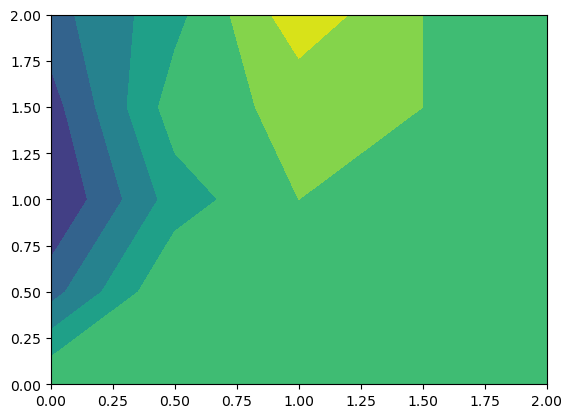

In [25]:
contour = plt.contourf(x_grid, y_grid, z_grid, cmap='viridis')

In [64]:
timer=TM(1,100)

HOUSE_LIGHT_ON = [*range(0,1,1)] + [*range(2,3,1)] + [*range(4,5,1)] + [*range(6,7,1)] +  [*range(8,9,1)] + [*range(10,11,1)] + [*range(12,13,1)] + [*range(14,15,1)] + [*range(16,17,1)] + [*range(18,19,1)] + [*range(20,21,1)] + [*range(22,23,1)] #[*range(9,10,1)] + [*range(11,12,1)] + [*range(13,14,1)] +[*range(13,14,1)]
dt = 0.1    
event_data = np.asarray([[0,1,1], [50,0,0], [25,1,1],
                      [50,0,0], [25,1,1], [50,0,0], 
                      [25,1,1], [50,0,0], [25,1,1], 
                      [50,0,0], [25,1,1], [50,0,0], 
                      [25,1,1], [50,0,0], [25,1,1], 
                      [50,0,0], [25,1,1], [50,0,0],
                      [25,1,1], [50,0,0], [25,1,1],
                      [50,0,0], [25,1,1], [50,0,0],
                      [25,1,1], [50,0,0], [25,1,1],
                      [50,0,0], [25,1,1], [50,0,0],
                      [25,1,1], [50,0,0], [25,1,1],
                      [25,1,1], [50,0,0], [25,1,1],
                      [25,1,1], [50,0,0], [25,1,1]])        
reward_arr = np.zeros(int(event_data[HOUSE_LIGHT_ON[-1]+2][0]/dt))
# For event, add a large amount of reward at the event and a little right before it 
for index, event in enumerate(event_data[1:]):
    # print(f'index: {index}, event: {event}')
    if index in HOUSE_LIGHT_ON or (index-1) in HOUSE_LIGHT_ON:
        if int(event[0]/dt) < reward_arr.shape[0]:
            reward_arr[int(event[0]/dt)] = 1
            exp_arr = np.exp(-.5 * np.arange(0, 20, dt))[::-1]
            reward_arr[int(event[0]/dt) - exp_arr.shape[0]:int(event[0]/dt)] = exp_arr

house_light_responding_values = activationAtIntervalEnd(timer, initiating_active_indices, next_house_light_event_time - event_time, NOISE)
responses = respond(house_light_responding_values, event_time, next_house_light_event_time, START_THRESHOLD, STOP_THRESHOLD, dt, seq_length, K, idx)
                   

if run_twice>0 and len(responses) > 0:
    run_twice-=1

reward = reward_arr[[int(r/dt) for r in responses]]
reward_vals.append(reward)

NameError: name 'initiating_active_indices' is not defined